<br><br><font color="gray">INTEG 440 / 640<br>MODULE 6 of *Doing Computational Social Science*</font>

# <font color="green" size=40>CENTRALITY, POWER, & INFLUENCE</font>

<br>

Dr. [John McLevey](http://www.johnmclevey.com)    
Department of Knowledge Integration   
Department of Sociology & Legal Studies     
University of Waterloo         

<hr>

* INTEG 440 (Undergraduate): This module is worth <font color='#437AB2'>**8%**</font> of your final grade. The questions in this module add up to 10 points. 
* INTEG 640 (Graduate): This module is worth <font color='#437AB2'>**5%**</font> of your final grade. The questions in this module add up to 10 points. 

<hr>

# Table of Contents 

* [Overview](#o)
* [Learning Outcomes](#lo) 
* [Prerequisite Knowledge](#pk) 
* [Assigned Reading](#ar) 
* [Question Links](#ql)
* [Packages Used in this Module](#packs)
* [Data Used in this Module](#data)
* [**Paths and Network Flow**](#pnf)
* [**Centrality, Power, and Influence**](#cpi)
* [**Structural Holes and Network Constraint**](#sh) 
* [**Identifying Peripheral Nodes**](#per)
* [References](#refs) 

<hr>   

# Overview <a id='o'></a>

Now that we know how to think in terms of networks, to construct network datasets, and to initialize `networkx` graph objects, we can start analyzing networks. This module introduces one of the most commonly applied set of methods in network science: centrality analysis. 

<hr>

# Learning Outcomes  <a id='lo'></a>

Upon successful completion of this module, you will be able to: 

1. Explain what paths in a network are and how they relate to common measures of centrality 
2. Compute, interpret, and compare centrality measures (especially degree, eigenvector, and betweenness)
3. Conduct and interpret an analysis of structural holes and brokerage 

<hr>

# Prerequisite Knowledge  <a id='pk'></a>

This module assumes basic comfort with the fundamentals of Python and knowledge of network thinking and relational data structures introduced in the previous module. 

<hr>

# Assigned Readings  <a id='ar'></a>

This module assumes you have completed the assigned readings, which are listed immediately below. The readings provide a detailed explanation of the core concepts covered in this module. 

* <font color="green">Matthew O. Jackson. 2019. Chapter 2: "Power and Influence: Central Positions in Networks" from *The Human Network*. Pantheon Books.</font> 

As always, I recommend that you (1) complete the assigned readings, (2) attempt to complete this module without consulting the readings, making notes to indicate where you are uncertain, (3) go back to the readings to fill in the gaps in your knowledge, and finally (4) attempt to complete the parts of this module that you were unable to complete the first time around.

This module notebook includes highly condensed overviews of *some* of the key material from the assigned reading. This is intended as a *supplement* to the assigned reading, *not as a replacement for it*. These high-level summaries do not contain enough information for you to successfully complete the exercises that are part of this module, and they do not cover every relevant topic. 

<hr>

# Question Links <a id='ql'></a>

Make sure you have answered all of the following questions before submitting this notebook on LEARN. 

1. [Question 1](#yt1) 
2. [Question 2](#yt2) 
3. [Question 3](#yt3) 
4. [Question 4](#yt4) 
5. [Question 5](#yt5) 
6. [Question 6](#yt6) 
7. [Question 7](#yt7) 

<hr>

# Packages Used in this Module  <a id='packs'></a> 

The cell below imports the packages that are necessary to complete this module. If there are any additional packages you wish to import, you may add them to this import cell. 

In [42]:
!pip install community

import pandas as pd 
import networkx as nx 
import community
import statistics

# not imported into the top-level networkx namespace, so we have to import it directly 
from networkx.algorithms.community import k_clique_communities 

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# make inline plots vector graphics instead of raster. 
%config InlineBackend.figure_format = 'svg'

# make Python quieter... 
import warnings
warnings.filterwarnings('ignore')

# Data Used in this Module  <a id='data'></a>

In this module, we will continue using the personal ego network datasets we constructed in the previous Module. That data was saved in the `data` directory as an edgelist and as an adjacency matrix. Here, we will load the edgelist version of the dataset. 

In [43]:
ego_el = pd.read_csv('data/jm_ego_data_el.csv')
ego = nx.from_pandas_edgelist(ego_el)
ego.name = 'Personal Network'
print(nx.info(ego))

Name: Personal Network
Type: Graph
Number of nodes: 62
Number of edges: 328
Average degree:  10.5806


We will also load ***your* ego network data**, created in the previous Module. Be sure to change the name of the file from `jm_ego_data_el.csv` to whatever you named your ego network edgelist data. 

In [44]:
your_file = 'ps_ego_data_el.csv'
ego_el_stu = pd.read_csv('data/{}'.format(your_file))
ego_stu = nx.from_pandas_edgelist(ego_el_stu)
ego_stu.add_edge('Robi Sanchez', 'Nathan Koo')
ego_stu.name = 'Personal Network'
print(nx.info(ego_stu))

Name: Personal Network
Type: Graph
Number of nodes: 50
Number of edges: 167
Average degree:   6.6800


Throughout this notebook I will include example analyses of my own network. At various parts of the notebook I will ask you to conduct and interpret a similar analysis of your personal network data. So make sure you correctly load your network -- you will need it to complete this Module. 

# Paths and Network Flow <a id='pnf'></a>

One of the most powerful ideas in social network analysis is that structural positions in networks affect people's ability to access or shape the flow of things -- such as resources, information, or knowledge -- over a network. These and other contagions, including simple contagions like infections and complex contagions like condom adoption and other behavioural changes (see Centola 2018), flow over paths on a network. Recall that Cristakis and Fowler argued that one of the "rules of life in the network" is that we are influenced by our friends, and by our friends' friends' friends. Paths are at the core of this argument, and many others like it. 

Most of the time, we don't examine paths on a network directly. Still, examining paths can be a useful way to deepen your understanding of key network concepts, such as centrality. As you may have realized while doing the assigned readings, most centrality scores are based on the idea that one's position in a network makes it easier for them to manipulate the flow of things -- such as information or resources -- between nodes. In fact, in a classic paper, Steve Borgatti (2005) argues that *all* centrality measures have implicit models and assumptions about how things flow on network paths, and that a common problem in centrality analyses is selecting a centrality measure that makes incorrect or unrealistic assumptions those flows. For example, does information tend to travel along the *shortest* paths between pairs of nodes, or does it flow more like an electrical current, as Brandes and Fleischer (2005) have proposed? The key point here is that selecting a centrality measure properly requires having at least some understanding of how things diffuse in a network. To do so, we need to be able to reason about paths. 

In a connected graph (i.e. with only one component), there are multiple paths that connect any given pair of nodes ($i$ and $j$). We can identify the shortest path between any two nodes in a network using the `shortest_path` function in `networkx`. If we use the function without specifying a pair of nodes (using the 'source' and 'target' parameters) it will compute the shortest paths between every possible start and end point. 

In [45]:
spaths = nx.shortest_path(ego)
# spaths # a LOT of text to print to screen... 

Alternatively, we can list the shortest path between two sources.

In [46]:
spath_specified = nx.shortest_path(ego, source='Kate D', target='Johan K')
spath_specified

['Kate D', 'Martin I', 'Eric K', 'Ally S', 'Peter C', 'Johan K']

In other words, in order for some information that Kate has to reach Johan, she would first have to share the information with our colleague Martin, who is connected to our colleague Eric, who knows my partner Ally, who knows my colleague Peter, who is also friends with Johan. *Remember, of course, that if I was in this network (I deleted myself), then Kate could simply tell me and I would tell Johan, bypassing Martin, Harry, Katie, and Peter.* This is a shortest path when I am *not* a broker in my own network. 

So what does this path look like? Let's visualize it. In the resulting network visualization, the path between Kate and Johan will be shown in purple. All other edges will be lightgray. 

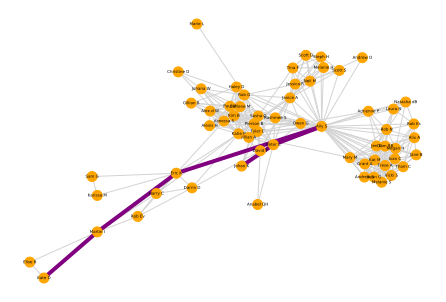

In [47]:
# get the path between Kate and Johan. 
spath_specified_edges = set(zip(spath_specified,spath_specified[1:]))
# get the layout coordinates
pos = nx.spring_layout(ego, iterations=500, seed = 13)
# plot the network 
nx.draw(ego, 
        pos = pos, 
        with_labels = True, 
        node_color = 'orange', 
        font_color = 'black', 
        edge_color = 'lightgray', 
        font_size = 4, 
        node_size = 100)
# plot the path on top of the existing network visualization 
nx.draw_networkx_edges(ego,pos,edgelist=spath_specified_edges,edge_color='purple',width=4)

If there is more than one shortest path -- and in this case there *are* multiple shortest paths between Kate and Johan -- then `networkx` picks one at random to return. If there are more than one, we can get the full list of shortest paths using the `all_shortest_paths()` function. Let's see the other paths between Kate and Johan.

In [48]:
for path in [path for path in nx.all_shortest_paths(ego, source='Kate D', target='Johan K')]:
    print(path)

['Kate D', 'Martin I', 'Harry C', 'Katie P', 'Peter C', 'Johan K']
['Kate D', 'Martin I', 'Eric K', 'Katie P', 'Peter C', 'Johan K']
['Kate D', 'Martin I', 'Eric K', 'Ally S', 'Peter C', 'Johan K']
['Kate D', 'Martin I', 'Harry C', 'Katie P', 'Pierson B', 'Johan K']
['Kate D', 'Martin I', 'Eric K', 'Katie P', 'Pierson B', 'Johan K']
['Kate D', 'Martin I', 'Eric K', 'Ally S', 'Pierson B', 'Johan K']
['Kate D', 'Martin I', 'Eric K', 'Vanessa S', 'Pierson B', 'Johan K']
['Kate D', 'Martin I', 'Harry C', 'Katie P', 'Sasha G', 'Johan K']
['Kate D', 'Martin I', 'Eric K', 'Katie P', 'Sasha G', 'Johan K']
['Kate D', 'Martin I', 'Eric K', 'Ally S', 'Sasha G', 'Johan K']
['Kate D', 'Martin I', 'Eric K', 'Vanessa S', 'Sasha G', 'Johan K']
['Kate D', 'Martin I', 'Harry C', 'Darrin D', 'David T', 'Johan K']
['Kate D', 'Martin I', 'Eric K', 'Darrin D', 'David T', 'Johan K']
['Kate D', 'Martin I', 'Rob Ev', 'Darrin D', 'David T', 'Johan K']
['Kate D', 'Martin I', 'Eric K', 'Ally S', 'David T', 'Johan

Because I know everyone in this network, I can imagine some of these paths being more likely to carry information than others. For example, Martin is far more likely to share information with Harry than with Eric, even though he knows both. And Eric is more likely to share information with Katie or Darrin than with Ally or Vanessa. Of course, *the computer doesn't know this*, and so thinks that each of these paths is equally likely. 

Shortest path **lengths** can also be computed, which can be useful when the distance between two nodes matters more than the specific paths connecting them. We can do this with the `shortest_path_length` function. We are counting edges on a path between a source and target node, so the *length will always be equal to 1 - the number of nodes in the path itself*.

In [49]:
nx.shortest_path_length(ego, source='Kate D', target='Johan K')

5

This tells us that regardless of the specific path, the closest that Kate and Johan can be in my current personal network is 5 steps. 

Finally, we can also compute the average of shortest paths in a connected network using the `average_shortest_paths` function.

In [50]:
aspl = np.round(nx.average_shortest_path_length(ego), 2)
aspl

2.21

### <font color="green">YOUR TURN! (Question 1)</font> <a id='yt1'></a>

Question is Worth: <font color="green">1 point</font>

The concept of things (e.g. information, resources) **flowing** over **paths** in a network is key to many centrality measures. One common way of thinking about power in social networks, then, is in terms of an ability to manipulate how things flow along **paths** in a network by virtue of one's structural position in a network. In the cell below, write an explanation of this idea using language a high school student could understand. Use examples of at least two centrality measures.  

Power in a network can sometimes be synonymous to the concept of "centrality" within the network. Centrality indicates how connected a node is within a network. These powerful nodes have the ability to control the flow of things that are passed on from node to node. Based on where they lie within this network and the other nodes they come in contact with, they can be influential towards what gets passed from one end to the other. These influences are critical to understand the larger behaviour and flow of the network. One great example of this is being invited to a popular person's party within highschool. Let's say you didn't get an invitation, based on the decision of this popular person, even though you know them, is a case of power within the social network. Through the basis of centrality and popularity, the person, a node, is able to manipulate the flow of invitation within the network to their paths of friends and decide who gets to come and who doesn't get to come. Another example can be of teachers who choose to provide education and knowledge to students enrolled within their classes. In this context, the teachers, who can be affiliated to other teachers and many other students, chooses to disclose such information to a particular class which is a reflection of their measure of power in centrality and ability to manipulate the flow of education. Another great example is Instagram's "Close Friends" feature which allows you to dicslose stories to a certain subset of your friends based on the people you add to the list. 

# Centrality, Power, and Influence <a id='cpi'></a>

Centrality analysis is one of the most important and common types of analysis you can do on network data. As discussed in the assigned readings, centrality analysis can help us identify nodes occupying positions that are important for some process that we care about. For example, we might want to identify nodes that are in a position to act as information brokers between clusters of collaborators in a collaboration network because we are interested in understanding who can potentially control or manipulate the flow of information over **paths** in a network. Or perhaps we are interested in understanding the structure of needle sharing networks to improve the effectiveness of a public health intervention.

There are literally *hundreds* of centrality scores, but here we will focus on centrality scores that are discussed in the assigned readings (especially Jackson's chapter). In particular we will focus on degree, eigenvector, and betweenness. Later in the Module we will consider two alternative measures -- network constraint and network embeddeddness -- that are similar in some respects to these measures but which differ in rather important ways. 

Remember, being more central is *not always preferable*. If we are talking about a friendship network through which interesting gossip flows, then having high betweenness centrality could be desirable because it exposes one to  interesting information from a variety of sources. However, if a cold virus was moving through the same network, lower betweenness would be preferable! 

### <font color="green">YOUR TURN! (Question 2)</font> <a id='yt2'></a>

Question is Worth: <font color="green">1 point</font>

In the cell below, explain (a) what each of these centralities (degree, eigenvector, and betweenness) is intended to capture, and (b) how they do so. *You do not have to include their equations*, but you are welcome to if you like. If you do, be sure to explain the equations; do not simply reproduce them. 

# Your Answer Here 

Please do not write more than 400 words. 

* Degree Centrality 
This measure is in relation to the number of nodes or links a certain node is connected to. In this level of measure, the higher the number of links, the more central the person is. For this, the degree centrality is the sum of links a pertaining node has which implies the number of nodes a node is linked to. In some contexts, this node can be overrepresented within analysis because of their connectedness and centrality within the network. 


* Eigenvector Centrality
Each node's centrality here is proportional to the sum of their friend's (linked nodes and their linked nodes and so forth) centrality. The score for each node is based on the natural extension of the node and the importance of the other nodes to the particular node of measurement. As such important nodes are endorsed more and given a higher attribution in the centrality score. The score is considered by the sum of nodes each subsequent node of connection has through some associated weight for each degree of connection. This goes to show that the alters an ego is connected to, provide a variation within the score and overall importance to the centrality. The notion is that if you're connected to other well-connected people, a.k.a nodes, then you have a better eigenvector centrality than a larger group of unconnected people. 


* Betweenness Centrality 
For a node within the network, they can embody the role of a broker and intermediary between other nodes which is in relevance to the betweenness a node inhabits. For the purpose of measurement, the number of shortest paths that pass through the node is an indication of the node's centrality. For the purpose of this measurement, shortest paths among all nodes must be calculated and then for each vertex, the number of shortest paths going through it are aggregated for analysis. Then this number is divided among all the shortest paths calculated to account for the final centrality score. As mentioned below, betweenness is a measure of the brokerage potential a node has. 

Computing centralities in `networkx` is straightforward. For example, to compute the three centralities we just covered on our personal networks, we can use the following functions: 

In [51]:
degree = nx.degree_centrality(ego)
eigenvector = nx.eigenvector_centrality(ego)
betweenness = nx.betweenness_centrality(ego)

We can check for the degree of any individual node directly by proving the ID of a node as an argument in the `degree()` method. For example:

In [52]:
specific_node = 'Megan H' # change to the name of someone in your personal network 
print("Node '{}' has a degree of {}.".format(specific_node, ego.degree(specific_node)))

Node 'Megan H' has a degree of 18.


The output of each function is a dictionary, where the keys are node ID and the values are the centrality scores. We can create a `pandas` `dataframe` from these `dicts`, with each row being the unique node ID. 

Not that the degree centrality scores are normalized (the scores are between 0 and 1). 

In [53]:
centralities = pd.DataFrame.from_dict([degree,eigenvector,betweenness]).T
centralities.columns = ["Degree", "Eigenvector", "Betweenness"]
centralities['Node ID'] = centralities.index
centralities.sample(15)

,Degree,Eigenvector,Betweenness,Node ID
Owen G,0.131148,0.081994,0.002476,Owen G
Darlene M,0.229508,0.124364,0.009690,Darlene M
Steph H,0.131148,0.056803,0.000328,Steph H
Kim B,0.229508,0.124364,0.009690,Kim B
Peter C,0.213115,0.112186,0.022947,Peter C
Kat M,0.229508,0.190563,0.000552,Kat M
Vanessa S,0.295082,0.141054,0.049807,Vanessa S
Christine D,0.049180,0.021845,0.000000,Christine D
Rashmee S,0.163934,0.104545,0.001136,Rashmee S
Kate D,0.032787,0.000359,0.000000,Kate D


As you know from the Jackson chapter, these centrality scores are designed to capture different ways of being central in a network. They differ, but they (and other centrality measures) are tend to be positively correlated. The strongest positive correlations tend to be with degree centrality, as degree is the foundation of many other centrality measures. Jackson explains the importance of node degree in the equation for eigenvector centrality, for example. 

Let's take a quick look at the correlations between centrality scores in our ego network. 

In [54]:
centralities.corr()

,Degree,Eigenvector,Betweenness
Degree,1.000000,0.909942,0.682568
Eigenvector,0.909942,1.000000,0.450131
Betweenness,0.682568,0.450131,1.000000


To help make sense of our centrality analysis, we can produce some simple visualizations and ranked lists. For example, let's produce a scatterplot comparing eigenvector centrality and betweenness centrality. We will also draw some dotted lines at the mean values for both centrality measures. Nodes positioned above or to the right of each line have centrality scores higher than the median score. We will also add names to the points that have betweenness scores higher than the median. These additional details are not necessary, but they can help with interpretation. 

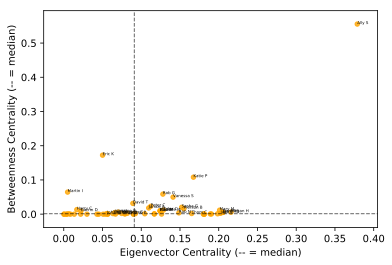

In [55]:
med_eig = statistics.median(centralities['Eigenvector'])
med_bet = statistics.median(centralities['Betweenness'])

plt.scatter(centralities['Eigenvector'], centralities['Betweenness'], s = 20, c = 'orange', alpha = 0.8)
plt.xlabel('Eigenvector Centrality (-- = median)', fontsize = 10)
plt.ylabel('Betweenness Centrality (-- = median)', fontsize = 10)
plt.tick_params(axis = 'both', which = 'major', labelsize = 10)
plt.axvline(x=med_eig, color = 'black', linewidth = 1, alpha = .6, linestyle = '--')
plt.axhline(y=med_bet, color = 'black', linewidth = 1, alpha = .6, linestyle = '--')

# we have to do a little extra work to get the text annotations on our scatterplot
for i, names in enumerate(centralities['Node ID']):
    if centralities['Betweenness'][i] > med_bet:
        x = centralities['Eigenvector'][i]
        y = centralities['Betweenness'][i]
        plt.text(x,y, names, fontsize=4)
    
plt.show()

How do we interpret an analysis like this? 

Somewhat unsurprsing to me, the nodes that this analysis surfaces -- especially those with higher than average betweenness *and* eigenvector centrality, on the right side of the vertical line -- are my partner (Ally), some my University of Waterloo colleagues (Katie, Rob, Vanessa, Janice, and Peter), the grad students who work in my research lab (Pierson, Sasha, Tyler), and some of my closest friends (Meghan, Rob, Thom, Ivan). 

The left of the vertical line includes people with high betweenness centrality and low eigenvector centrality, and is primarily made up of a fairly close group of colleagues and collaborators (Harry Collins, Martin Innes, Darrin Durant, Rob Evans, and Eric Kennedy), a collaborator from another line of research I am involved in (David Tindall), and some of my professor friends. 

*You should have a similar reaction and interpretation when you look at the most central people in your personal network.* In other words, since you know these people and you know your own network reasonably well, you should have an intuitive sense of why you see the names you see. Hopefully this helps deepen your understanding of these centrality measures. 

### <font color="green">YOUR TURN! (Question 3)</font> <a id='yt3'></a>

Question is Worth: <font color="green">2 points</font>

Use the cell below to reproduce the centrality analysis conducted above **on your own ego network**. Be sure to compute centralities, construct and name a dataframe (**use a different name**), and produce the scatterplot. 

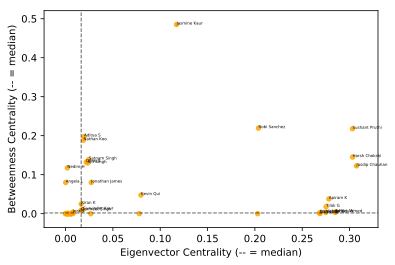

In [56]:
# Your Answer Here 

degree = nx.degree_centrality(ego_stu)
eigenvector = nx.eigenvector_centrality(ego_stu)
betweenness = nx.betweenness_centrality(ego_stu)

centralities_stu = pd.DataFrame.from_dict([degree,eigenvector,betweenness]).T
centralities_stu.columns = ["Degree", "Eigenvector", "Betweenness"]
centralities_stu['Node ID'] = centralities_stu.index
centralities_stu.sample(15)

centralities_stu.corr()

med_eig = statistics.median(centralities_stu['Eigenvector'])
med_bet = statistics.median(centralities_stu['Betweenness'])

plt.scatter(centralities_stu['Eigenvector'], centralities_stu['Betweenness'], s = 20, c = 'orange', alpha = 0.8)
plt.xlabel('Eigenvector Centrality (-- = median)', fontsize = 10)
plt.ylabel('Betweenness Centrality (-- = median)', fontsize = 10)
plt.tick_params(axis = 'both', which = 'major', labelsize = 10)
plt.axvline(x=med_eig, color = 'black', linewidth = 1, alpha = .6, linestyle = '--')
plt.axhline(y=med_bet, color = 'black', linewidth = 1, alpha = .6, linestyle = '--')

# we have to do a little extra work to get the text annotations on our scatterplot
for i, names in enumerate(centralities_stu['Node ID']):
    if centralities_stu['Betweenness'][i] > med_bet:
        x = centralities_stu['Eigenvector'][i]
        y = centralities_stu['Betweenness'][i]
        plt.text(x,y, names, fontsize=4)
    
plt.show()

### <font color="green">YOUR TURN! (Question 4)</font> <a id='yt4'></a>

Question is Worth: <font color="green">1 point</font>

Write up an interpretation of the most central nodes in your personal network. Feel free to use my interpretation of my own network as a basic guideline. 

Most of the central nodes within my personal network are accumulated on different ends of the spectrum relative to Eigenvector centrality. This implies that there are some connected to more important, endorsing nodes (most of which are program friends whom are highly intertwined within my network such as Sushant, Harsh, Jasdip, etc.) and then some of my other closer friends who have less of a reach within the network as they don't know as many people within the network I specified. Those with less of a reach are ones within my friend circle who have a relatively high betweenness centrality score indicating their brokerage potential. If I were to open up the list, to a larger set of my friends, primarily out of school, this could be a different story. Among most of these friends, lies Jasmine, who has the highest score in betweeness centrality acting as the means of shortest path and brokerage between my outside-school friends and school friends. She acts as the bridge among most of these people. A lot of my family members lie on the left bottom corner of the median line indicating a much lower centrality overall for them as they're connected through me mostly.

## Current Flow Betweenness

As previously mentioned, centrality analysis has implicit models of how things flow over networks. Betweenness centrality as it is often applied is based on the notion that nodes tend to have more power in a network if they tend to sit on paths that other people depend on for exchanges. More specifically, nodes with high betweenness are on the *shortest* (geodesic) paths between other pairs of actors. 

Remember that Borgatti and others have argued that centrality measures should be selected based on the models of flow they imply? Brandes and Fleischer (2005) and Newman (2005) have developed variations on the classic betweenness centrality measure that assumes a *different* model of information flow on a network, and thus often produces different node rankings in applications of centrality analysis. The main idea is that information flow in a network is like an electrical current, which is less complex than it may seem at first. 

Imagine there are two nodes in a network that want to connect, but for one reason a node that lies on the geodesic path (shortest) between them blocks or otherwise complicates the relationship. If there is another path along which these two nodes can connect, they will use that alternative path *even if it is not the shortest path available*.  

In other words, current flow betweenness, unlike classical betweenness, assumes that nodes will use all paths available to them, but they will tend to prefer the shorter paths. If short paths are blocked, they will resort to other paths that are longer and less efficient, but which get the job done. 

The algorithm that computes current flow betweenness is more computationally demanding than classical betweenness and will take longer to compute for large networks. 

In [57]:
betweenness_flow = nx.current_flow_betweenness_centrality(ego)

Let's add our flow betweenness scores to our centralities `dataframe` and then compare scores for the two versions of betweenness centrality with a simple scatterplot. This time we will use `Seaborn` to create the scatterplot because we can easily add a regression line and marginal histograms to the plot. 

In terms of the regression line, we are going to fit a lowess line. [Lowess](https://en.wikipedia.org/wiki/Local_regression) is a nonparametric regression method that, among other things, is very useful for scatterplot smoothing. In this case, it will help summarize the relationship between both centrality scores. (Note that we could have fit a linear regression line to emphasize departures from the linear model. If you want to see what that looks like, set the argument `lowess = True` to `False`.) 

In [58]:
centralities['Current Flow Betweenness'] = betweenness_flow.values()
centralities.sample(5)

,Degree,Eigenvector,Betweenness,Node ID,Current Flow Betweenness
Laura B,0.114754,0.079053,0.000537,Laura B,0.031216
Kim B,0.229508,0.124364,0.009690,Kim B,0.054897
Adrienne P,0.114754,0.078400,0.001585,Adrienne P,0.046838
Tyler C,0.245902,0.128702,0.011906,Tyler C,0.065767
Johana W,0.114754,0.055895,0.001763,Johana W,0.031219


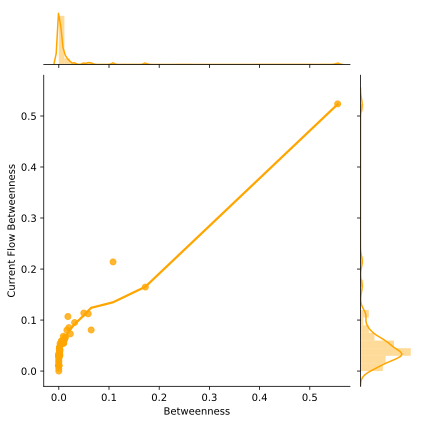

In [59]:
sns.jointplot(centralities['Betweenness'], centralities['Current Flow Betweenness'], 
              lowess=True, kind='reg', xlim=[-.03,.58], ylim=[-.03,.58], color='orange');

As you can see in the plot above, the two centrality scores are fairly similar, but the current flow implementation assigns higher betweenness scores to some nodes that have low  scores using the classic implementation. As a result the relationship between the two scores is not linear, and there is more variability in the current flow betweenness scores, especially on the low end. 

Let's rerun our comparison with eigenvector centrality using current flow betweenness rather than classical betweenness. 

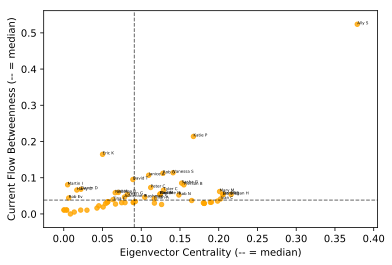

In [60]:
med_eig = statistics.median(centralities['Eigenvector'])
med_bet = statistics.median(centralities['Current Flow Betweenness'])

plt.scatter(centralities['Eigenvector'], centralities['Current Flow Betweenness'], s = 20, c = 'orange', alpha = 0.8)
plt.xlabel('Eigenvector Centrality (-- = median)', fontsize = 10)
plt.ylabel('Current Flow Betweenness (-- = median)', fontsize = 10)
plt.tick_params(axis = 'both', which = 'major', labelsize = 10)
plt.axvline(x=med_eig, color = 'black', linewidth = 1, alpha = .6, linestyle = '--')
plt.axhline(y=med_bet, color = 'black', linewidth = 1, alpha = .6, linestyle = '--')

# we have to do a little extra work to get the text annotations on our scatterplot
for i, names in enumerate(centralities['Node ID']):
    if centralities['Current Flow Betweenness'][i] > med_bet:
        x = centralities['Eigenvector'][i]
        y = centralities['Current Flow Betweenness'][i]
        plt.text(x,y, names, fontsize=4)
    
plt.show()

As you can see, there is more variation in the betweenness scores when we use current flow, but in this particular case the top nodes uncovered are mostly the same. Perhaps the biggest difference is that there is more difference in the scores that are above and below the median current flow betweenness scores. 

We can, of course, also produce simple list of nodes ranked by their centrality. For example: 

In [61]:
centralities['Current Flow Betweenness'].sort_values(ascending = False).head(20)

Ally S       0.523748
Katie P      0.213973
Eric K       0.164662
Vanessa S    0.113753
Rob G        0.112231
Janice A     0.106952
David T      0.095167
Sasha G      0.085126
Martin I     0.080567
Pierson B    0.080342
Peter C      0.072995
Darrin D     0.068273
Harry C      0.066059
Tyler C      0.065767
Mary M       0.061938
Jessica R    0.059508
Neil M       0.058673
Paul M       0.054897
Darlene M    0.054897
Kim B        0.054897
Name: Current Flow Betweenness, dtype: float64

### <font color="green">YOUR TURN! (Question 5)</font> <a id='yt5'></a>

Question is Worth: <font color="green">2 points</font>

Use the cell below to compute Current Flow Betweenness for *your* ego network and add it to the centralities `dataframe` that you created for *your* ego network. Finally, print the names and current flow betweenness scores for the top 20 nodes in your personal network. 

In [76]:
# Your Answer Here 
betweenness_flow = nx.current_flow_betweenness_centrality(ego_stu)
centralities_stu['Current Flow Betweenness'] = betweenness_flow.values()
centralities_stu['Current Flow Betweenness'].sort_values(ascending = False).head(20)


Jasmine Kaur      0.486623
Aditya S          0.261104
Robi Sanchez      0.247121
Dilraj S          0.246019
Sushant Pruthi    0.241554
Satnam Singh      0.199816
Harsh Chokshi     0.198645
Nathan Koo        0.189853
Ajit Singh        0.181680
Jasdip Chauhan    0.174474
Kevin Qui         0.132612
Nedim H           0.130102
Apiram K          0.121578
Tilak G           0.094629
Gurvinder Kaur    0.083908
Angela L          0.080215
Jonathan James    0.080215
Kiran K           0.080078
Gurmeet Singh     0.070366
Jeffrey W         0.064334
Name: Current Flow Betweenness, dtype: float64

# Structural Holes and Constraint <a id='sh'></a>

So far we have discussed degree, betweenness, and eigenvector centralities. Each of these is intended to capture different ways of being central in network. Of these three measures, betweenness is typically interpreted as emphasizing *brokerage* potential; in other words, nodes with high betweenness are in a position to *broker* the flow of information, knowledge, resources, and other things by virtue of being *between* cohesive subgroups in a network. 

Betweenness is widely-used as a measure of brokerage, but it is not the only one. Constraint is one popular alternative, developed by the sociologist Ron Burt (2004; 2005) in his research on brokerage and social capital. Burt's model of brokerage built on the sociologist Mark Granovetter's famous ["strength of weak ties" argument](https://youtu.be/g3bBajcR5fE) argument that information, opinions, and behaviours tend to be fairly homogenous within clusters of densely connected people and heterogeneous across clusters of densely connected people. Novel information generally travels along the weak ties connecting groups of people who are held together by strong ties. 

Burt built on this argument by pointing out that the pattern of connections among an ego's alters can provide advantages and disadvantages to a would be broker. If a ego's connections are well-connected to one another, then they will tend to share a lot of the same information, ideas, resources, and behaviours. The time that ego puts in to maintaining these relationships does not yield a lot of novel information for them. However, if ego's connections are not especially well-connected to one another, then there is less redundant information flowing between those connections, and ego can benefit from more diverse information within their personal networks. This affords them a "vision advantage," in which their network position enables them to see and know other ways of doing things that other people are unable to see. This "vision advantage" makes them more likely to have good ideas than their peers, whose connections "constrain" them in a network. 

Burt developed the constraint measure to capture these dynamics. Nodes with high constraint scores are nodes who have more 'redundant' ties, which is a rather cold way of saying that those people are more or less interchangable in terms of the information and resources they provide to our would be broker. Nodes that are *less* constrained have fewer redundant ties and are more likely to be exposed to novel information and new ways of thinking and being. 

While Burt is clearly focused on understanding and explaining brokerage, he does acknowledge that there are benefits to being in a more constrained position. The key benefit is being embedded in stronger and more trusted relationships. 

Computing constraint is very similar to computing the centrality scores we discussed earlier, or eccentricity. We simply use the `constraint()` function and get back a `dict` of values. 

In [63]:
constraint = nx.constraint(ego)
centralities['Constraint'] = constraint.values()

The 20 *least constrained* people in my personal network are: 

In [64]:
centralities['Constraint'].sort_values(ascending=True).head(20)

Ally S       0.075842
Katie P      0.126396
Rob G        0.144366
Vanessa S    0.162267
Sasha G      0.165106
David T      0.168432
Pierson B    0.172390
Janice A     0.179864
Tyler C      0.180612
Dom RB       0.189236
Jen D        0.189236
Megan H      0.190808
Peter C      0.193085
Rob N        0.196512
Mary M       0.200806
Jillian A    0.201264
Thom C       0.206267
Ivan C       0.206390
Darlene M    0.207126
Paul M       0.207126
Name: Constraint, dtype: float64

Constraint and betweenness are both commonly used by researchers interested in identifying potential brokers in a network. If we plotted both measures against one another, we would see that the highly constrained nodes tend to have low betweenness scores. However, there is quite a range of betweenness scores among the nodes that are less constrained. Below, let's plot constraint against current flow betweenness. Again, we will also add a lowess line and marginal histograms to the plot. 

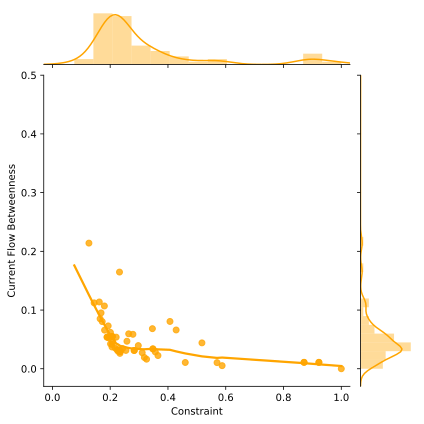

In [65]:
sns.jointplot(centralities['Constraint'], centralities['Current Flow Betweenness'], 
              lowess=True, kind='reg', color='orange', xlim=[-.03,1.03], ylim=[-.03,.5]);

### <font color="green">YOUR TURN! (Question 6)</font> <a id='yt6'></a>

Question is Worth: <font color="green">1 point</font>

In the code cell below, (1) add constraint scores to the centralities `dataframe` object for *your* ego network and (2) make a scatterplot showing the relationship between constraint and current flow betweenness centrality *in your ego network*. 

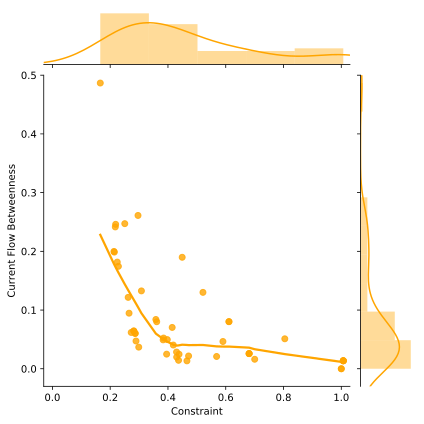

In [66]:
# Your Answer Here 
constraint_stu = nx.constraint(ego_stu)
centralities_stu['Constraint'] = constraint_stu.values()
sns.jointplot(centralities_stu['Constraint'], centralities_stu['Current Flow Betweenness'], 
              lowess=True, kind='reg', color='orange', xlim=[-.03,1.03], ylim=[-.03,.5]);

# Identifying Peripheral Nodes <a id='per'></a>

Most of the time researchers are focused on identifying *central* nodes. Another way of thinking about this issue of centrality is to flip things around and focus on identifying *peripheral* nodes. Being peripheral is not necessarily the same thing as having low centrality or being highly constrained. For example, one can have a low score on some given centrality measure (e.g. betweenness) without actually being peripheral to a network. 

In `networkx`, one way of computing how peripheral a node is involves calculating the "eccentricity" of nodes in the network. A node's eccentricity is equal to the maximum distance from the node to add other nodes in the network. We can then classify nodes as being in the periphery of a network if their eccentricity is equal to the diameter of a network. Recall from earlier that the diameter is the shortest path between the two nodes that are the furthest apart from each other in a network. If the network diameter is 5, nodes with an eccentricity score of 5 can be considered peripheral. 

As with the centrality scores previously discussed, the `networkx` function `eccentricity()` returns a `dict`. Like `degree()`, we can compute the eccentricity score for any node by providing its unique ID as an argument. 

In [67]:
ecc = nx.eccentricity(ego, v=None)
ecc

{'Ally S': 3,
 'Megan H': 4,
 'Ivan C': 4,
 'Alix A': 4,
 'Thom C': 4,
 'Rob N': 4,
 'Laura B': 4,
 'Owen G': 4,
 'Rashmee S': 4,
 'Rob G': 4,
 'Katie P': 3,
 'Vanessa S': 3,
 'Peter C': 4,
 'Pierson B': 4,
 'Sasha G': 4,
 'Tyler C': 4,
 'Jillian A': 4,
 'David T': 4,
 'Adrienne P': 4,
 'Rob Es': 4,
 'Steph H': 4,
 'Scott S': 4,
 'Jen D': 4,
 'Dom RB': 4,
 'Trese A': 4,
 'Grant A': 4,
 'Mary M': 4,
 'Kat M': 4,
 'Melanie S': 4,
 'Andrew S': 4,
 'Vicki S': 4,
 'Sean G': 4,
 'Jane B': 4,
 'Eric K': 3,
 'Janice A': 4,
 'Jessica R': 4,
 'Andrew O': 4,
 'Haley D': 4,
 'Kim B': 4,
 'Paul M': 4,
 'Darlene M': 4,
 'Neil M': 4,
 'Tina F': 4,
 'Scott D': 4,
 'Melanie H': 4,
 'Natasha dB': 4,
 'Alexis H': 4,
 'Alex d W': 4,
 'Johana W': 4,
 'Christine D': 4,
 'Marie L': 5,
 'Darrin D': 3,
 'Harry C': 3,
 'Gillian B': 4,
 'Anabel QH': 5,
 'Johan K': 5,
 'Rob Ev': 4,
 'Martin I': 4,
 'Elise B': 5,
 'Kate D': 5,
 'Sam G': 4,
 'Karissa M': 4}

The function `periphery()` simplifies this process. It compute the diameter and eccentricity scores and then returns a list of nodes that are in the graph's periphery. We can use this function rather than computing the periphery scores manually. 

In [68]:
nodes_in_the_per = nx.periphery(ego)
nodes_in_the_per

['Marie L', 'Anabel QH', 'Johan K', 'Elise B', 'Kate D']

## Centrality and Network Visualization

To continue with some visual reasoning here, let's connect these scores to some visualizations of the network. We will produce a series of visualizations where the node size changes based on some quantitative measure, such as a centrality score. As you study the images, try to understand why some nodes have higher or lower scores on a centrality measure given the connections they are embedded in and their more general location in the network structure. 

In the first visualization, node sizes are uniform. 

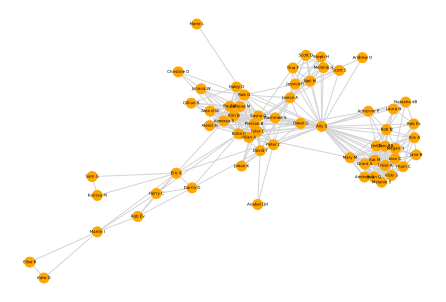

In [69]:
nx.draw(ego, 
        pos = pos, 
        with_labels = True, 
        node_color = 'orange', 
        font_color = 'black', 
        edge_color = 'lightgray', 
        font_size = 4, 
        node_size = 100)

And now let's size nodes based on their degree centrality. 

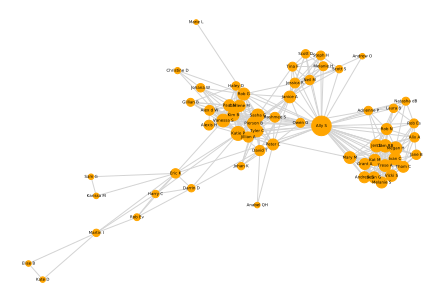

In [70]:
nx.draw(ego, 
        pos = pos, 
        with_labels = True, 
        node_color = 'orange', 
        font_color = 'black', 
        edge_color = 'lightgray', 
        font_size = 4,  
        node_size = [s*500 + 15 for s in centralities['Degree']])

Node sizes based on eigenvector centrality. 

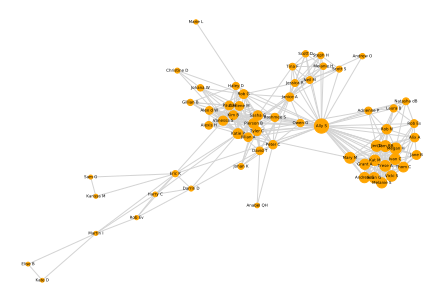

In [71]:
nx.draw(ego, 
        pos = pos, 
        with_labels = True, 
        node_color = 'orange', 
        font_color = 'black', 
        edge_color = 'lightgray', 
        font_size = 4, 
        node_size = [s*500 + 15 for s in centralities['Eigenvector']])

Node sizes based on current flow betweenness centrality. 

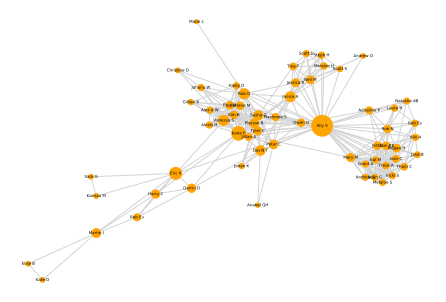

In [72]:
nx.draw(ego, 
        pos = pos, 
        with_labels = True, 
        node_color = 'orange', 
        font_color = 'black', 
        edge_color = 'lightgray', 
        font_size = 4, 
        node_size = [s*800 + 15 for s in centralities['Current Flow Betweenness']])

### <font color="green">YOUR TURN! (Question 7)</font> <a id='yt7'></a>

Question is Worth: <font color="green">2 points</font>

In the cell below, 

1. compute layout coordinates for the nodes in your network using the `spring_layout()` function,
2. visualize *your* ego network in a fashion similar to what I have done above, and 
3. size nodes based on current flow betweenness 

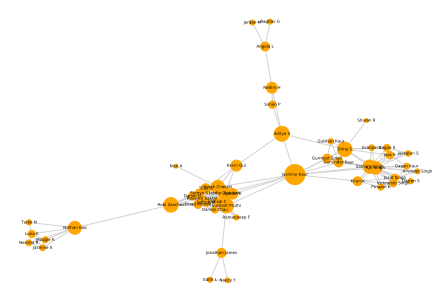

In [73]:
# Your Answer Here 
# get the layout coordinates
pos = nx.spring_layout(ego_stu, iterations=500, seed = 13)

nx.draw(ego_stu, 
        pos = pos, 
        with_labels = True, 
        node_color = 'orange', 
        font_color = 'black', 
        edge_color = 'lightgray', 
        font_size = 4, 
        node_size = [s*800 + 15 for s in centralities_stu['Current Flow Betweenness']])

Finally, let's write our centralities `dataframe` to disk so that we can load it in our next Module. Be sure to write the `dataframe` with your centralities scores to disk as well, so that you can continue working with your ego network in the next Module. 

In [74]:
centralities_stu.to_csv('data/centralities_egonet_ps.csv', index=False)

<hr>

# <font color="green">Do You See Something That Could be Better?</font>

I am committed to collecting student feedback to continuously improve this course for future students. I would like to invite you to help me make those improvements. 

As you worked on this module, did you notice anything that could be improved? For example, did you find a typo in the module notebook? Did you find the explanation of a particular concept or block of code confusing? Is there something that just isn’t clicking for you? 

If you have any feedback for the content in this module, please enter it into the text block below. I will review feedback each week and make a list of things that should be changed before the next offering. 

Please know that *nothing you say here, however critical, will impact how I evaluate your work in this course*. There is no risk that I will assign a lower grade to you if you provide critical feedback. In fact, if the feedback you provide is thoughtful and constructive, I will assign up to 3% bonus marks on your final course grade. 

Thanks for your help improving the course! 

# Your Feedback Here :-) 

<hr>

# REFERENCES <a id='refs'></a>

* Borgatti, Stephen. 2005. "Centrality and network flow." *Social Networks*. 27(1): 55-71.
* Brandes, Ulrik, and Daniel Fleischer. 2005. "Centrality measures based on current flow." *Annual symposium on theoretical aspects of computer science.* Springer, Berlin, Heidelberg. 
* Jackson, Matthew O. 2019. *The Human Network*. Pantheon Books.